In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
sys.path.insert(1, '..')

from scipy.stats import beta
from scipy.stats import lognorm
import h5py

import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

In [2]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

[-0.02085388 -0.02119802 -0.02145622 ... -0.01931315 -0.01990852
 -0.02042321]
[-0.02084976 -0.02119372 -0.0214521  ... -0.01930908 -0.01990454
 -0.020419  ]
[-0.02069832 -0.02103326 -0.02128173 ... -0.01919235 -0.0197757
 -0.02027986]


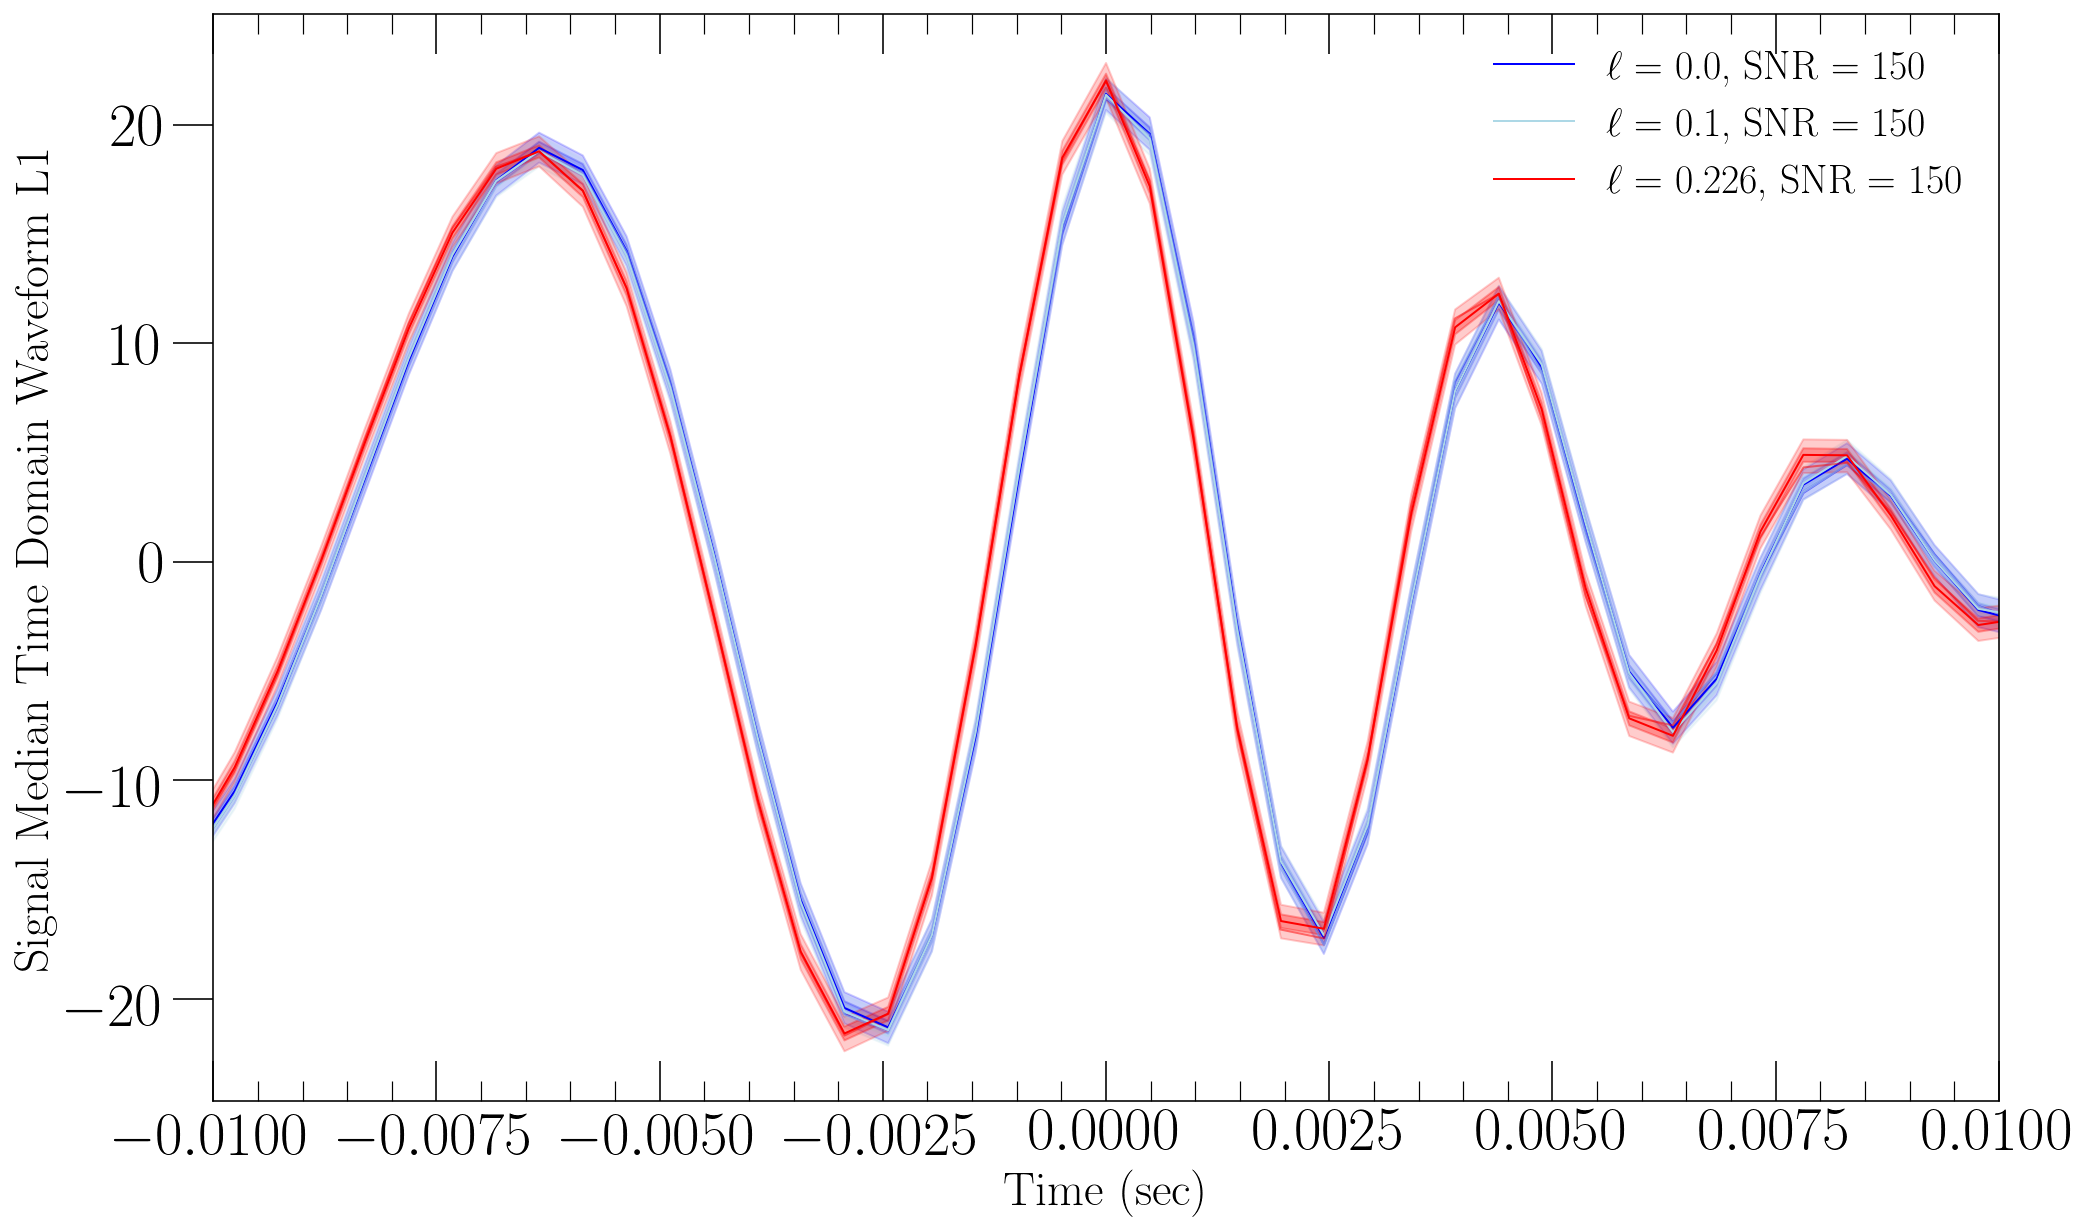

In [25]:
def GetMedianData(ell, SNR):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ell = str(ell).replace('.','p')
    SNR = str(SNR)
    
    base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/post/signal/"
 
    ## Grab Livingston data
    f = base_dir + "signal_median_time_domain_waveform_L1.dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    time = SubtractPeakTime(time, d1)
    
    return time, d1, d2, d3, d4, d5


def GetInjectedData(ell, SNR):
    
    ell = str(ell).replace('.','p')
    SNR = str(SNR)
    base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/post/"
    
    f = base_dir + 'whitened_data_L1.dat'
    data = np.loadtxt(f)
    print(data)
    
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    
    time = SubtractPeakTime(time, data)
    return time, data
    
def PlotMedianData(ell, SNR, c):
    
    ## Plot the Bayeswave data
    time, d1, d2, d3, d4, d5 = GetMedianData(ell, SNR)
    label = r'$\ell$ = ' + str(ell) + ', SNR = ' + str(SNR) 
    
    plt.plot(time, d1, '-', lw = 1.0, alpha = 1.0, c=c, label=label)  
    plt.fill_between(time, d2, d3, alpha = 0.3, color=c, edgecolor=None)
    plt.fill_between(time, d4, d5, alpha = 0.2, color=c, edgecolor=None)
    
    time, data = GetInjectedData(ell, SNR)
    plt.plot(time, data, '-', color=c, lw = 1.0, alpha=0.5)
        
plt.figure(figsize=(16,10))

PlotMedianData(0.0, 150, 'blue')
PlotMedianData(0.1, 150, 'lightblue')
PlotMedianData(0.226, 150, 'red')

plt.legend(frameon=False, fontsize=20)
plt.xlim(-0.01, 0.01)
plt.xlabel('Time (sec)')
plt.ylabel('Signal Median Time Domain Waveform L1')
plt.savefig('MediansClose.pdf')


plt.show()



[-0.02085388 -0.02119802 -0.02145622 ... -0.01931315 -0.01990852
 -0.02042321]
[-0.02084976 -0.02119372 -0.0214521  ... -0.01930908 -0.01990454
 -0.020419  ]
[-0.02069832 -0.02103326 -0.02128173 ... -0.01919235 -0.0197757
 -0.02027986]


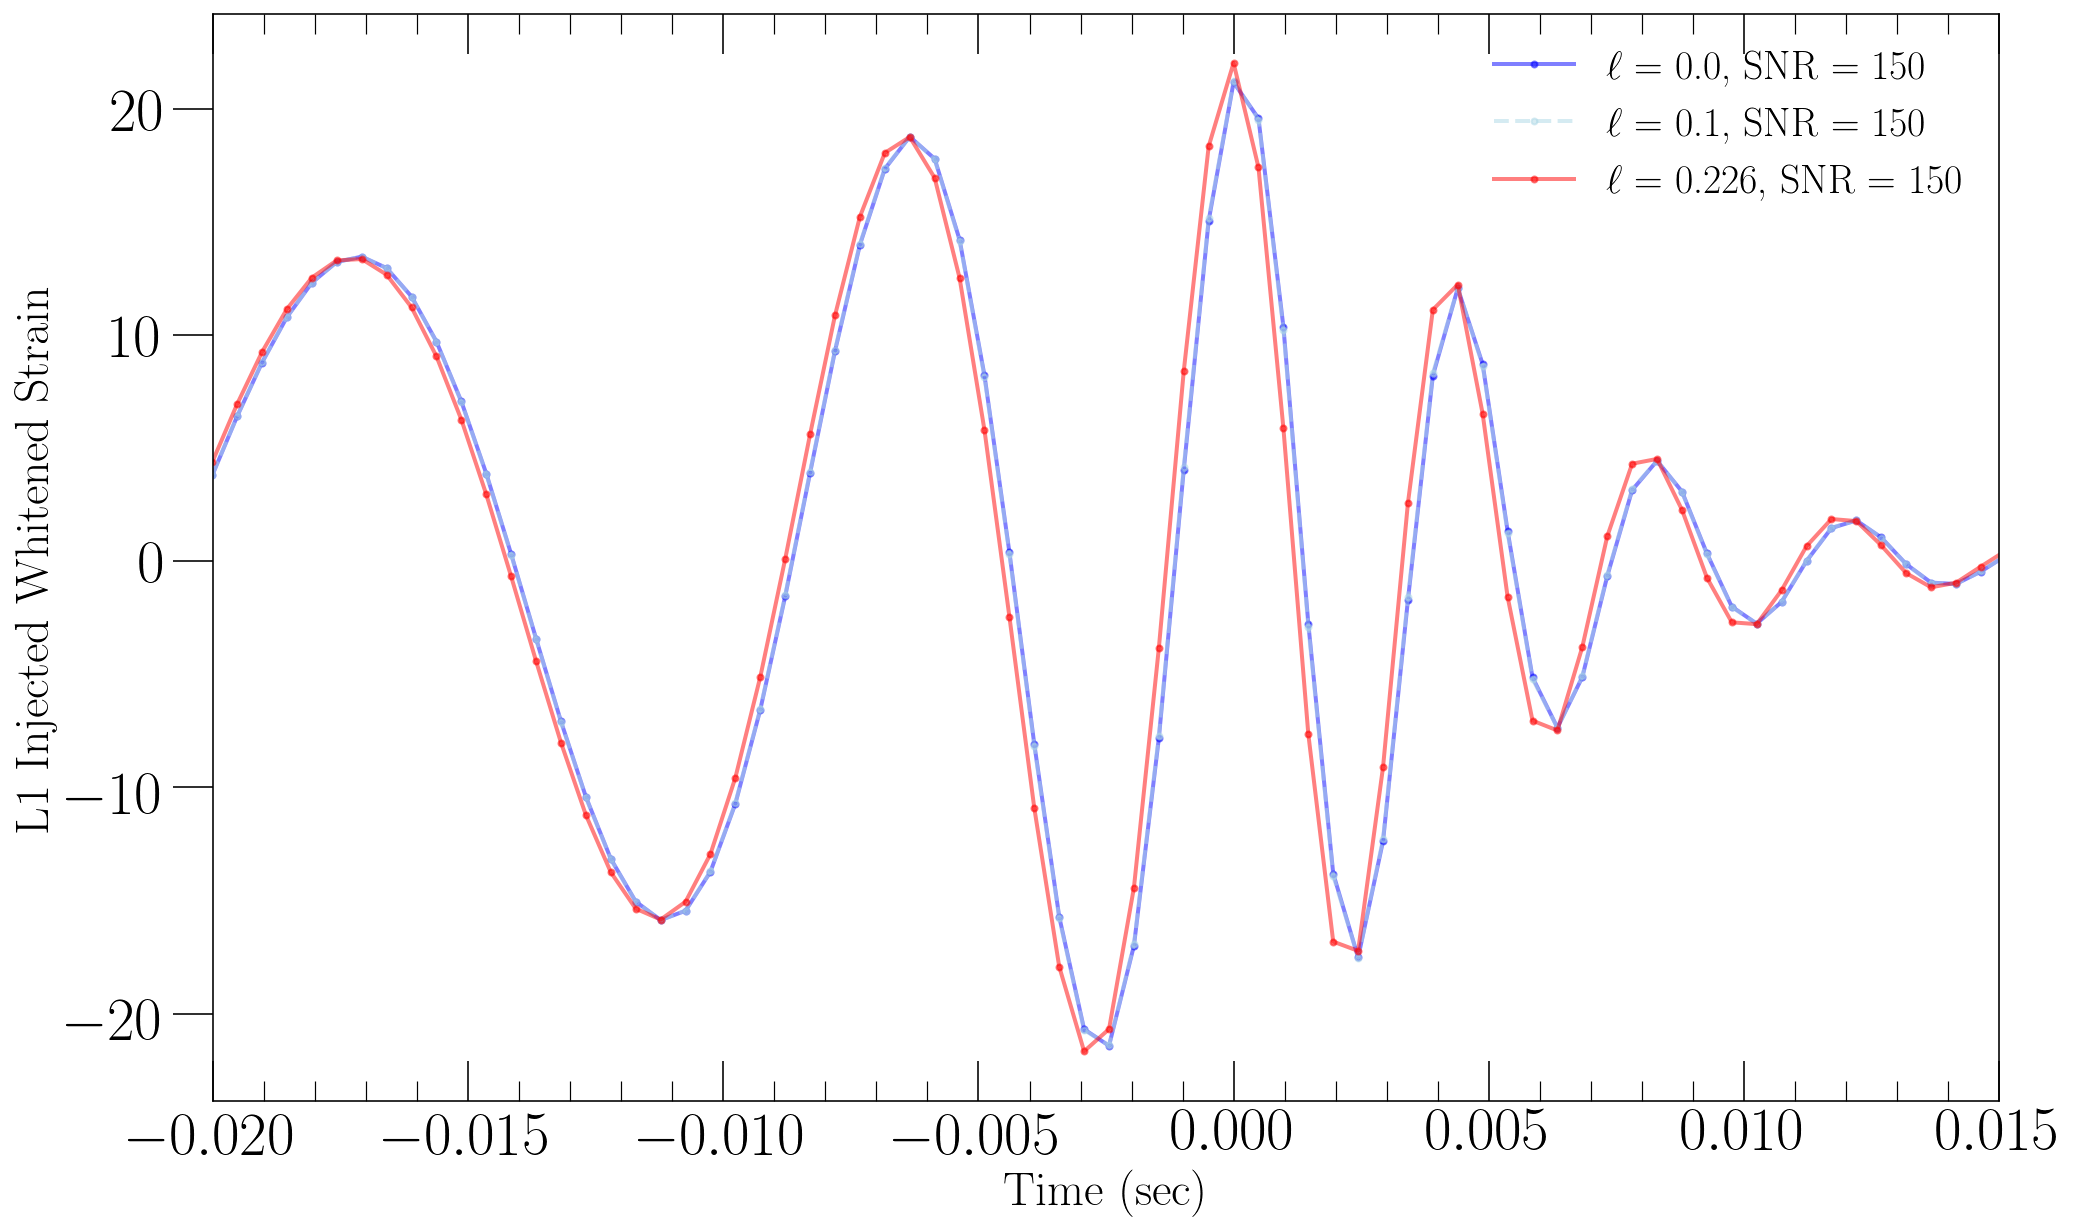

In [20]:
def PlotInjections(ell, SNR, c, ls):
    
    label = r'$\ell$ = ' + str(ell) + ', SNR = ' + str(SNR)
    time, data = GetInjectedData(ell, SNR)
    plt.plot(time, data, ls, color=c, lw = 2.0, alpha=0.5, label=label, markersize=3)
        
plt.figure(figsize=(16,10))

PlotInjections(0.0, 150, 'blue', '-o')
PlotInjections(0.1, 150, 'lightblue', '--o')
PlotInjections(0.226, 150, 'red', '-o')

plt.legend(frameon=False, fontsize=20)
plt.xlim(-0.02, 0.015)
plt.xlabel('Time (sec)')
plt.ylabel('L1 Injected Whitened Strain')
plt.savefig('Injections.pdf')


plt.show()

